import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score , mean_absolute_error,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import category_encoders as ce

%matplotlib inline

data = pd.read_excel('Data_Train (1).xlsx')

data.head()

data.columns

data.describe()

data.info()

data.isnull().sum()

# Removing units

data['Power'] = data['Power'].str.split(' ').str[0]
# including nan rows there is data in this column of 'null' value
data.loc[data.Power == 'null','Power'] = np.NaN

data['Mileage'] = data['Mileage'].apply(lambda x: re.sub('[$kmpl|km/kg]','',str(x)))
data['Engine'] = data['Engine'].apply(lambda x: re.sub('[$CC]','',str(x)))
data['Power'] = data['Power'].apply(lambda x: re.sub('[$bhp]','',str(x)))

data.head()

data['Mileage'] = pd.to_numeric(data['Mileage'],errors='coerce')
data['Engine'] = pd.to_numeric(data['Engine'],errors='coerce')
data['Power'] = pd.to_numeric(data['Power'],errors='coerce')

# Removing Outlayers


data.drop(data[data['Kilometers_Driven'] >= 6500000].index, axis=0, inplace=True)

sns.heatmap(data.corr(),cmap='coolwarm')
plt.show()

In [33]:
from itertools import combinations

In [34]:
object_cols = data.select_dtypes("object").columns
object_cols

Index(['Name', 'Location', 'Fuel_Type', 'Transmission', 'Owner_Type'], dtype='object')

In [35]:
low_cardinality_cols = [col for col in object_cols if data[col].nunique() < 15]
low_cardinality_cols.append("Brand")

In [36]:
data['Name'] = data['Name'].apply(lambda x: re.sub('Rover','',str(x)))

In [37]:
carnames = data.Name.str.split(expand=True)[[0,1,2]]
carnames.rename(columns={0:'Brand',1:'Model',2:'Type'}, inplace=True)
data = data.join(carnames)
data = data.drop("Name", axis=1)
data.head()
interactions = pd.DataFrame(index=data.index)

In [38]:
# Iterate through each pair of features, combine them into interaction features
for features in combinations(low_cardinality_cols,2):
    
    new_interaction = data[features[0]].map(str)+"_"+data[features[1]].map(str)
    
    encoder = LabelEncoder()
    interactions["_".join(features)] = encoder.fit_transform(new_interaction)

In [39]:
data = data.join(interactions) #append to the dataset
data.head(5)

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,...,Location_Fuel_Type,Location_Transmission,Location_Owner_Type,Location_Brand,Fuel_Type_Transmission,Fuel_Type_Owner_Type,Fuel_Type_Brand,Transmission_Owner_Type,Transmission_Brand,Owner_Type_Brand
0,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,...,26,19,28,217,0,0,1,4,38,16
1,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,...,32,21,32,236,2,3,12,4,33,9
2,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,...,8,5,6,48,6,10,43,4,32,8
3,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,...,6,5,6,53,2,3,19,4,38,16
4,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,...,9,6,12,64,1,5,5,2,0,32


In [40]:
features = data.drop(["Price"], axis=1)
target = data["Price"]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=0)

In [41]:
X_train.isnull().sum()

Location                     0
Year                         0
Kilometers_Driven            0
Fuel_Type                    0
Transmission                 0
Owner_Type                   0
Mileage                      1
Engine                      22
Power                      106
Seats                       28
Brand                        0
Model                        0
Type                         0
Location_Fuel_Type           0
Location_Transmission        0
Location_Owner_Type          0
Location_Brand               0
Fuel_Type_Transmission       0
Fuel_Type_Owner_Type         0
Fuel_Type_Brand              0
Transmission_Owner_Type      0
Transmission_Brand           0
Owner_Type_Brand             0
dtype: int64

In [42]:
num_cols = X_train.select_dtypes("number")
null_num_cols = num_cols.columns[num_cols.isnull().any()]

for cols in null_num_cols:
    X_train.loc[:,cols] = X_train.loc[:,cols].fillna(X_train.groupby('Brand')[cols].transform('median'))
    X_train.loc[:,cols] = X_train.loc[:,cols].fillna(X_train[cols].mean())

    X_test.loc[:,cols] = X_test.loc[:,cols].fillna(X_test.groupby('Brand')[cols].transform('median'))
    X_test.loc[:,cols] = X_test.loc[:,cols].fillna(X_test[cols].mean())

/home/percy/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [43]:
data.select_dtypes("object").nunique()

Location         11
Fuel_Type         5
Transmission      2
Owner_Type        4
Brand            31
Model           214
Type            344
dtype: int64

In [44]:
OHE_cat_features = ["Fuel_Type","Transmission", "Location", "Owner_Type", "Brand"]
OH_encoder = OneHotEncoder(sparse=False,handle_unknown='ignore')

OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[OHE_cat_features]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test[OHE_cat_features]))

OH_cols_train.index = X_train.index
OH_cols_test.index = X_test.index

OH_cols_train.columns = OH_encoder.get_feature_names(OHE_cat_features)
OH_cols_test.columns = OH_encoder.get_feature_names(OHE_cat_features)

X_train_enc = X_train.join(OH_cols_train)
X_test_enc = X_test.join(OH_cols_test)

In [45]:
X_train_enc.drop(OHE_cat_features, axis=1, inplace = True)
X_test_enc.drop(OHE_cat_features, axis=1, inplace = True)

In [46]:
X_train_enc.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Model,Type,Location_Fuel_Type,Location_Transmission,...,Brand_Mitsubishi,Brand_Nissan,Brand_Porsche,Brand_Renault,Brand_Skoda,Brand_Smart,Brand_Tata,Brand_Toyota,Brand_Volkswagen,Brand_Volvo
245,2007,72000,17.00,1086.0,82.0,5.0,Santro,Xing,30,19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2175,2013,70961,25.80,1498.0,98.6,5.0,Amaze,EX,18,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4134,2016,34004,15.40,1497.0,117.3,7.0,BR-V,i-VTEC,4,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4975,2016,41810,20.73,1373.0,91.1,5.0,Ciaz,ZXi,10,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2473,2018,68737,26.21,1248.0,88.5,5.0,Ciaz,ZDi,9,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
target_cat_features = X_train_enc.select_dtypes('object').columns
target_enc = ce.TargetEncoder(cols=target_cat_features)
target_enc.fit(X_train[target_cat_features], y_train)
X_train_enc = X_train_enc.join(target_enc.transform(X_train[target_cat_features]).add_suffix('_enc'))
X_test_enc = X_test_enc.join(target_enc.transform(X_test[target_cat_features]).add_suffix('_enc'))
X_train_enc.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Model,Type,Location_Fuel_Type,Location_Transmission,...,Brand_Porsche,Brand_Renault,Brand_Skoda,Brand_Smart,Brand_Tata,Brand_Toyota,Brand_Volkswagen,Brand_Volvo,Model_enc,Type_enc
245,2007,72000,17.00,1086.0,82.0,5.0,Santro,Xing,30,19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.791967,1.738571
2175,2013,70961,25.80,1498.0,98.6,5.0,Amaze,EX,18,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.766282,3.978158
4134,2016,34004,15.40,1497.0,117.3,7.0,BR-V,i-VTEC,4,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.579124,9.060769
4975,2016,41810,20.73,1373.0,91.1,5.0,Ciaz,ZXi,10,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.626034,6.809325
2473,2018,68737,26.21,1248.0,88.5,5.0,Ciaz,ZDi,9,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.626034,6.349655


In [48]:
object_cols = X_train_enc.select_dtypes('object')
X_train_enc.drop(object_cols, axis=1, inplace = True)
X_test_enc.drop(object_cols, axis=1, inplace = True)

In [49]:
X_train_enc.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Location_Fuel_Type,Location_Transmission,Location_Owner_Type,Location_Brand,...,Brand_Porsche,Brand_Renault,Brand_Skoda,Brand_Smart,Brand_Tata,Brand_Toyota,Brand_Volkswagen,Brand_Volvo,Model_enc,Type_enc
245,2007,72000,17.00,1086.0,82.0,5.0,30,19,31,212,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.791967,1.738571
2175,2013,70961,25.80,1498.0,98.6,5.0,18,13,19,142,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.766282,3.978158
4134,2016,34004,15.40,1497.0,117.3,7.0,4,3,2,23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.579124,9.060769
4975,2016,41810,20.73,1373.0,91.1,5.0,10,7,10,77,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.626034,6.809325
2473,2018,68737,26.21,1248.0,88.5,5.0,9,7,10,77,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.626034,6.349655


In [50]:
pcorr = X_train_enc.join(y_train).corr()
imp_corr_cols = pcorr[['Price']][pcorr['Price']>-0.25].iloc[:-1].index

X_train_enc = X_train_enc[imp_corr_cols]
X_test_enc = X_test_enc[imp_corr_cols]
X_train_enc.head()

,Year,Kilometers_Driven,Engine,Power,Seats,Location_Fuel_Type,Location_Transmission,Location_Owner_Type,Location_Brand,Owner_Type_Brand,...,Brand_Porsche,Brand_Renault,Brand_Skoda,Brand_Smart,Brand_Tata,Brand_Toyota,Brand_Volkswagen,Brand_Volvo,Model_enc,Type_enc
245,2007,72000,1086.0,82.0,5.0,30,19,31,212,62,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.791967,1.738571
2175,2013,70961,1498.0,98.6,5.0,18,13,19,142,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.766282,3.978158
4134,2016,34004,1497.0,117.3,7.0,4,3,2,23,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.579124,9.060769
4975,2016,41810,1373.0,91.1,5.0,10,7,10,77,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.626034,6.809325
2473,2018,68737,1248.0,88.5,5.0,9,7,10,77,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.626034,6.349655


In [51]:
from xgboost import XGBRegressor

In [62]:
base_xgbr = XGBRegressor(objective='reg:squarederror', tree_method='hist')
base_xgbr.fit(X_train_enc,y_train)

base_xgbr.score(X_test_enc,y_test) #r2 score

0.9103538730991136

3.654495054037329


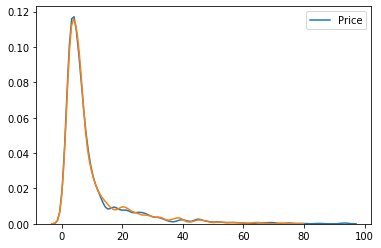

In [53]:
yhat_xgbr = base_xgbr.predict(X_test_enc)
print(mean_squared_error(y_test, yhat_xgbr,squared = False))
sns.kdeplot(y_test)
sns.kdeplot(yhat_xgbr)

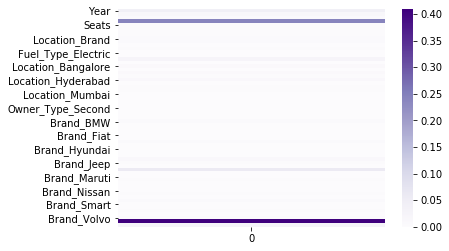

In [54]:
feat_imp = pd.DataFrame(base_xgbr.feature_importances_, index=X_train_enc.columns)
sns.heatmap(feat_imp, cmap='Purples')

In [55]:
impfeat = pd.Series(base_xgbr.feature_importances_, index=X_train_enc.columns)
impcols = impfeat[impfeat>0.005].index
impfeat.head()

Year                 0.042067
Kilometers_Driven    0.016122
Engine               0.008582
Power                0.244379
Seats                0.004545
dtype: float32

In [56]:
X_train_enc = X_train_enc[impcols]
X_test_enc = X_test_enc[impcols]

In [57]:
from lightgbm import LGBMRegressor

In [58]:
base_lgbmr = LGBMRegressor()
base_lgbmr.fit(X_train_enc, y_train)
base_lgbmr.score(X_test_enc,y_test)

0.9108067016053222

3.4092659789585302


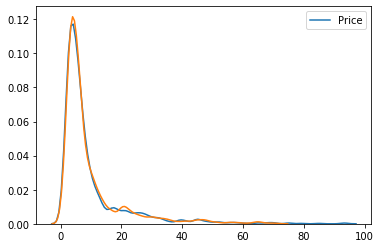

In [59]:
yhat_lgbmr = base_lgbmr.predict(X_test_enc)
print(mean_squared_error(y_test, yhat_lgbmr, squared=False))
sns.kdeplot(y_test)
sns.kdeplot(yhat_lgbmr)

#initial grid search
param_grid = {
    "learning_rate": [0.15],
    "max_depth": [5,8,10,12],
    "min_child_weight": [3,5,6,8],
    "n_estimators": [300,500,800,1000,1200],
    "num_leaves": [20,25,40,50],
    "subsample": [0.3,0.5]
}
gscv_lgbm = GridSearchCV(estimator=base_lgbmr, param_grid=param_grid, n_jobs=-1, verbose=5, cv=4)

gscv_lgbm.fit(X_train_enc, y_train)
gscv_lgbm.best_params_
gscv_lgbm.score(X_test_enc,y_test) #r2 score

gscv_lgbm.best_params_

In [312]:
param_grid2 ={
    "learning_rate": [0.15],
    "max_depth": [5],
    "n_estimators": [1500],
    "num_leaves": [27],
    'reg_alpha': [0.001],
    'reg_lambda': [0]
}
gscv_lgbm2 = GridSearchCV(estimator=base_lgbmr, param_grid=param_grid2, n_jobs=-1, verbose=5, cv=4)

In [313]:
gscv_lgbm2.fit(X_train_enc, y_train)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.0s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.15], 'max_depth': [5],
                         'n_estimators': [1500], 'num_leaves': [27],
                         'reg_alpha': [0.001]

In [314]:
print(gscv_lgbm2.best_params_)
print(gscv_lgbm2.score(X_test_enc,y_test)) #r2 score

{'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 1500, 'num_leaves': 27, 'reg_alpha': 0.001, 'reg_lambda': 0}
0.9229145864591319


In [308]:
tuned_lgbmr = LGBMRegressor(**gscv_lgbm2.best_params_)
tuned_lgbmr.fit(X_train_enc, y_train)
tuned_lgbmr.score(X_test_enc,y_test)

0.9229145864591319

10.045273170307286


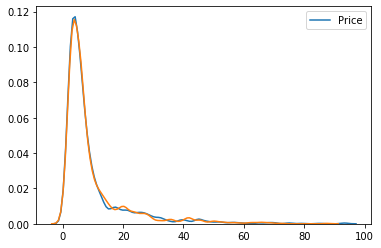

In [309]:
yhat_lgbmr = tuned_lgbmr.predict(X_test_enc)
print(mean_squared_error(y_test, yhat_lgbmr))
sns.kdeplot(y_test)
sns.kdeplot(yhat_lgbmr)

In [362]:

rfr = RandomForestRegressor(n_estimators = 100,random_state=0)
rfr.fit(X_train_enc,y_train)

pred = rfr.predict(X_test_enc)

print(r2_score(y_test,pred),mean_absolute_error(y_test,pred),mean_squared_error(y_test,pred))

0.9092303350345442 1.342623114934346 11.828516424470678
